In [1]:
import csv
import pandas as pd
import json
import pickle

import os
import pandas as pd
import csv
import numpy as np
import pickle
from klepto.archives import dir_archive
import sys
import nltk
import string
import re
import fasttext
from pymagnitude import *

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
def preprocess_csv(ids, texts, indexes):
    reasult = {'id': [], 'text': [], 'class': []}
    if indexes != 'n/a':
        is_hate = json.loads(indexes)
    else:
        is_hate = []
    post_ids = [post_id_line[2:].strip() for post_id_line in ids.strip().split('\n')]
    posts = [text[2:].strip() for text in texts.strip().split('\n')]
    for index, row in enumerate(zip(post_ids, posts)):
        if len(row[1]) > 0:
            if row[0][0] == '.':
                new_post_id = row[0][1:].strip()
            else:
                new_post_id = row[0].strip()
            reasult['id'].append(new_post_id)
            if row[1][0] == '.':
                stripped_text = row[1][1:].strip()
            else:
                stripped_text = row[1].strip()
            reasult['text'].append(stripped_text)
            if (index + 1) in is_hate:
                reasult['class'].append(1)
            else:
                reasult['class'].append(2)
    return pd.DataFrame.from_dict(reasult)


with open('hsd/Reddit/gab.csv') as csv_file:
    posts_df = pd.DataFrame(columns = ['id', 'text', 'class']) 
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    for row in csv_reader:
        posts_df = posts_df.append(preprocess_csv(row[0], row[1], row[2]), ignore_index=True)

with open('hsd/Reddit/reddit.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    for row in csv_reader:
        posts_df = posts_df.append(preprocess_csv(row[0], row[1], row[2]), ignore_index=True)

# posts_df = posts_df.drop(['class'], axis=1)

# with open('hsd/Reddit/info.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     next(csv_reader, None)
#     for row in csv_reader:
#         posts_df = posts_df.append({ 'id': row[0], 'text': row[3] }, ignore_index=True)

# posts_df.to_csv('hsd/Reddit/clean_gab.csv', index=False)


In [39]:
#info_dataframe = pd.read_csv('hsd/Reddit/info.csv')

In [3]:
def pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'): 
        return wordnet.ADJ 
    elif nltk_tag.startswith('V'): 
        return wordnet.VERB 
    elif nltk_tag.startswith('N'): 
        return wordnet.NOUN 
    elif nltk_tag.startswith('R'): 
        return wordnet.ADV 
    else:           
        return None

def word_tokenization(tweet):
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(tweet)
    words = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w[0]) if pos_tagger(w[1]) is None else lemmatizer.lemmatize(w[0], pos_tagger(w[1])) for w in tags]
    tags = [x[1] for x in tags]
    return words, tags

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = text_string.encode('ascii', 'ignore').decode('ascii')
    parsed_text = re.sub(space_pattern, ' ', parsed_text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = parsed_text.strip('#')
    list_words, tag_list = word_tokenization(parsed_text)
    parsed_text = " ".join(list_words)
    tag_str = ' '.join(tag_list)
    return parsed_text, tag_str

def basic_tokenize(tweet):
    tweet = " ".join(re.split(" ", tweet.lower())).strip()
    return tweet.split()

# def get_pos_string(tweet):
#     text = preprocess(tweet)
#     tokens = word_tokenize(text)
#     tags = nltk.pos_tag(tokens)
#     tag_list = [x[1] for x in tags]
#     tag_str = ' '.join(tag_list)
    
    # return tag_str

def pad_words(words, length):
    if len(words) >= length:
        return words[:length]
    else:
        additional = length - len(words)
        return words + ['EMPTY']*additional

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

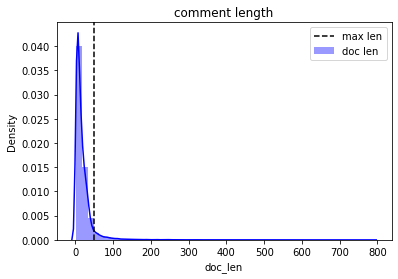

In [5]:
posts_df['lemmatized_text'] = posts_df['text'].apply(lambda words: preprocess(words)[0])
posts_df['doc_len'] = posts_df['lemmatized_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(posts_df['doc_len'].mean() + posts_df['doc_len'].std()).astype(int)
sns.distplot(posts_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [6]:
posts_df.head()

,id,text,class,lemmatized_text,doc_len
0,39869714,i joined gab to remind myself how retarded jew...,1,join gab remind retard jew hater You would typ...,12
1,39845588,This is what the left is really scared of. ...,2,This leave really scared,4
2,39848775,That literally looks like a monkey. Why are we...,2,That literally look like monkey Why suppose pr...,13
3,39911017,Dumb Cunt,1,Dumb Cunt,2
4,37485560,It makes you an asshole.,2,It make asshole,3


In [7]:
max_seq_len

49

In [9]:
posts_df.to_csv('hsd/Reddit/all_data.csv')

In [46]:
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 100000

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(posts_df['lemmatized_text'].tolist())  #leaky
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
# word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
# word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  42027


In [47]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [48]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
vecs = Magnitude(MagnitudeUtils.download_model('http://magnitude.plasticity.ai/fasttext/medium/crawl-300d-2M.magnitude'))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = vecs.query(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [49]:
words_not_found

[]

In [4]:
posts_df = None

def preprocess_csv(ids, texts, indexes):
    reasult = {'id': [], 'text': [], 'class': []}
    if indexes != 'n/a':
        is_hate = json.loads(indexes)
    else:
        is_hate = []
    post_ids = [post_id_line[2:].strip() for post_id_line in ids.strip().split('\n')]
    posts = [text[2:].strip() for text in texts.strip().split('\n')]
    for index, row in enumerate(zip(post_ids, posts)):
        if len(row[1]) > 0:
            if row[0][0] == '.':
                new_post_id = row[0][1:].strip()
            else:
                new_post_id = row[0].strip()
            reasult['id'].append(new_post_id)
            if row[1][0] == '.':
                stripped_text = row[1][1:].strip()
            else:
                stripped_text = row[1].strip()
            reasult['text'].append(stripped_text)
            if (index + 1) in is_hate:
                reasult['class'].append(1)
            else:
                reasult['class'].append(2)
    return pd.DataFrame.from_dict(reasult)


# with open('hsd/Reddit/gab.csv') as csv_file:
#     posts_df = pd.DataFrame(columns = ['id', 'text', 'class']) 
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     next(csv_reader, None)
#     for row in csv_reader:
#         posts_df = posts_df.append(preprocess_csv(row[0], row[1], row[2]), ignore_index=True)

with open('hsd/Reddit/reddit.csv') as csv_file:
    posts_df = pd.DataFrame(columns = ['id', 'text', 'class']) 
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    for row in csv_reader:
        posts_df = posts_df.append(preprocess_csv(row[0], row[1], row[2]), ignore_index=True)

posts_df['lemmatized_text'] = posts_df['text'].apply(lambda words: preprocess(words)[0])

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(posts_df, test_size=0.2, random_state=0, stratify=posts_df[['class']])

In [6]:
train.to_csv('hsd/Reddit/train_reddit.csv')
test.to_csv('hsd/Reddit/test_reddit.csv')

In [2]:
dataframe = pd.read_csv('hsd/Reddit/info.csv')

In [5]:
dataframe['lemmatized_text'] = dataframe['text'].apply(lambda words: preprocess(words)[0])

In [6]:
dataframe.to_csv('hsd/Reddit/validate.csv')